In [21]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import config as c
from assim_tools import *
from assim_tools.state import read_field

import models.topaz.v5 as tp5
import dataset.prep_obs.insitu as insitu


In [23]:
c.time = '202310230000'
time = s2t(c.time)

In [20]:
c.state_info = parse_state_info(c)

In [24]:
k_list = list(set([r['k'] for i,r in c.state_info['fields'].items() if r['time']==time]))
c.z_file = c.work_dir + '/analysis/'+c.time+'/z_coords.bin'
c.z = np.zeros((len(k_list), c.ny, c.nx))
for k in range(len(k_list)):
    rec_id = [i for i,r in c.state_info['fields'].items() if r['time']==time and r['k']==k_list[k]][0]
    zfld = read_field(c.z_file, c.state_info, c.mask, 0, rec_id)
    if c.state_info['fields'][rec_id]['is_vector']:
        c.z[k, ...] = zfld[0, ...]
    else:
        c.z[k, ...] = zfld

In [11]:
c.obs_info = parse_obs_info(c)

In [17]:
c.obs_info['records']

{0: {'name': 'ocean_temp',
  'source': 'prep_obs.insitu',
  'model': 'topaz.v5',
  'dtype': 'float',
  'is_vector': False,
  'units': 'K',
  'z_units': 'm',
  'pos': 0,
  'err': {'type': 'normal',
   'std': 0.1,
   'hcorr': 0.0,
   'vcorr': 0.0,
   'tcorr': 0.0,
   'cross_corr': array([1., 0.])},
  'hroi': 200000.0,
  'vroi': inf,
  'troi': inf,
  'impact_on_state': array([1., 1., 1.]),
  'obs': [37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   37.43,
   

In [18]:
obs_file = '/cluster/work/users/yingyue/exp1/analysis/202310230000/prior_obs.bin'

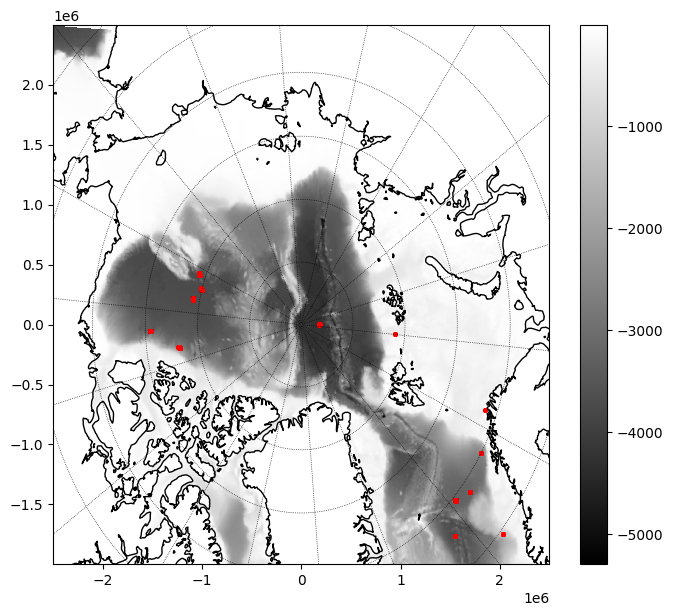

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))

im = c.grid.plot_field(ax, c.z[-1,...], cmap='gist_gray')
plt.colorbar(im)

c.grid.plot_land(ax)

obs_rec = c.obs_info['records'][1]
ax.scatter(obs_rec['x'], obs_rec['y'], 20, color='r', marker='.')


In [5]:
path = c.work_dir + '/forecast/'+c.time+'/topaz.v5'
grid = tp5.read_grid(path)
mask = tp5.read_mask(path, grid)

In [6]:
ONEM = 9806.
nz = 50
dz = np.zeros((nz, grid.ny, grid.nx))
for k in range(nz):
    dz[k, ...] = tp5.read_var(path, grid, name='ocean_layer_thick', member=10, k=tp5.levels[k]) / ONEM
z = np.cumsum(-dz, axis=0)
z[np.isnan(z)] = 0

In [7]:
var = np.zeros((nz, grid.ny, grid.nx))
for k in range(nz):
    var[k,...] = tp5.read_var(path, grid, name='ocean_temp', member=10, k=tp5.levels[k])

In [8]:
datapath = c.data_dir + '/prep_obs.insitu'

obs = insitu.read_obs(datapath, grid, mask, z, name='ocean_temp', time=datetime(2023, 10, 22))

In [9]:
j = 400
dy = 100000 ##meter
inds = np.where(np.abs(np.array(obs['y'])-grid.y[j,0]) < dy)

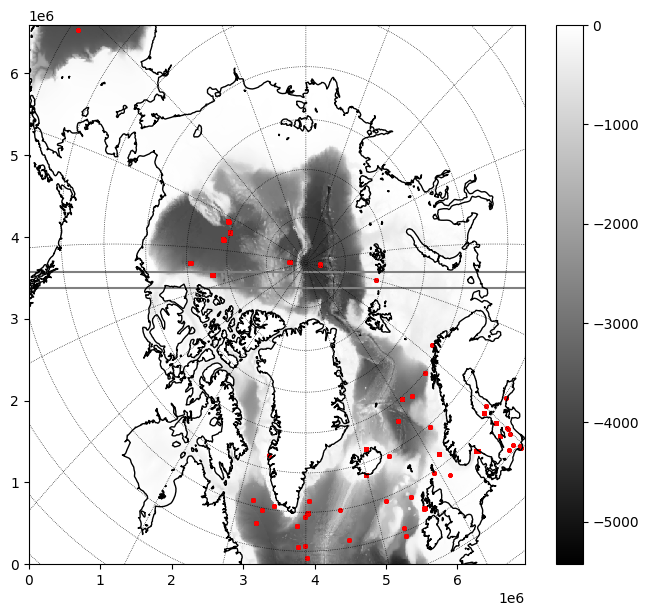

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))

im = grid.plot_field(ax, z[-1,...], cmap='gist_gray')
plt.colorbar(im)

grid.plot_land(ax)

ax.scatter(obs['x'], obs['y'], 20, color='r', marker='.')

ax.plot(grid.x[j,:], grid.y[j,:]+dy, color='gray')
ax.plot(grid.x[j,:], grid.y[j,:]-dy, color='gray')

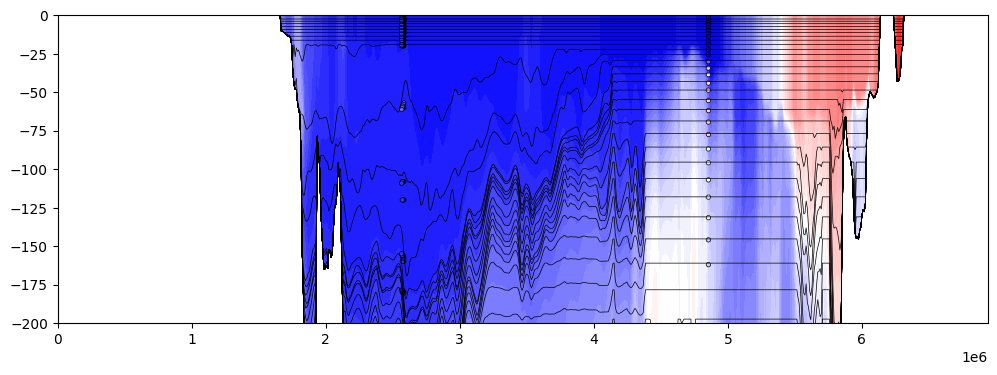

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

x, k = np.meshgrid(grid.x[j, :], np.arange(nz))

vmin = -2
vmax = 8
cmap = [plt.cm.bwr(x) for x in np.linspace(0, 1, round(vmax-vmin)+1)]
ax.contourf(x, z[:, j, :], var[:, j, :], np.arange(vmin, vmax, (vmax-vmin)/40), cmap=plt.cm.bwr)

##show isopycnal grid
ax.contour(x, z[:, j, :], k, np.arange(0,nz+1,1)-1e-10, colors='k', linewidths=0.5)

#ax.set_xlim(3e6, 5e6)
ax.set_ylim(-200, 0)

##show obs value
vout = np.array(obs['obs'])[inds]
cind = np.maximum(np.minimum(np.round(vout-vmin), int(np.round(vmax-vmin))), 0).astype(int)
ax.scatter(np.array(obs['x'])[inds], np.array(obs['z'])[inds], 10, color=np.array(cmap)[cind, 0:3], edgecolor='k', linewidth=0.5)
